<a href="https://colab.research.google.com/github/srg-lc/iddm/blob/main/NDF_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Modelo de deteção de dispositivos IoT feito com base no dataset do seguinte trabalho: https://www.sciencedirect.com/science/article/pii/S0167404820302418#bfn0001 usando o algoritmo Neural Decision Forest, que pode ser visto em ação em: https://keras.io/examples/structured_data/deep_neural_decision_forests/


### Importando dataset a partir do Github
O dataset está comprimido o que possibilita o upload gratuito no git e reduz o custo de tráfego. 

In [1]:
import urllib.request
url = "https://github.com/srg-lc/iddm/blob/main/data.zip?raw=true"
print ("download start!")
filename, headers = urllib.request.urlretrieve(url, filename="data.zip")
print ("download complete!")
print ("download file location: ", filename)

download start!
download complete!
download file location:  data.zip


### Importando bibliotecas necessárias

In [2]:
# Setup
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from sklearn import preprocessing
from sklearn import metrics
from matplotlib import pyplot as plt
import math

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

2021-12-12 08:41:47.314541: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-12 08:41:47.314565: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Criando Header dos dados, descompactando e carregando CSV dataset e resetando o índice.

In [3]:
CSV_HEADER = [
    "FIRST_SWITCHED",          
    "IN_BYTES",
    "IN_PKTS",
    "IPV4_DST_ADDR",
    "L4_DST_PORT",
    "L4_SRC_PORT",
    "LAST_SWITCHED",          
    "PROTOCOL",
    "SRC_TOS",
    "TCP_FLAGS",
    "IP",
    "DURATION",
    "device_model",
    "partition",          
    "SRC_AS",
    "DST_AS",
    "INPUT_SNMP",
    "OUTPUT_SNMP",
    "IPV4_SRC_ADDR",
    "MAC",          
    "category",          
    "type",          
    "date",          
    "inter_arrival_time",                
]
data_url = (
    "data.zip"
)
data = pd.read_csv(data_url, header=None, low_memory=False, names=CSV_HEADER)
data = data.drop(index=[0])
data = data.reset_index(drop=True)
data.head()

,FIRST_SWITCHED,IN_BYTES,IN_PKTS,IPV4_DST_ADDR,L4_DST_PORT,L4_SRC_PORT,LAST_SWITCHED,PROTOCOL,SRC_TOS,TCP_FLAGS,...,SRC_AS,DST_AS,INPUT_SNMP,OUTPUT_SNMP,IPV4_SRC_ADDR,MAC,category,type,date,inter_arrival_time
0,1579047004.0,240.0,4.0,52.9.239.18,5222.0,3696.0,1579042809.0,6.0,0.0,2.0,...,0.0,0.0,6.0,1.0,192.168.1.227,00:16:6C:7F:82:21,IoT,IoT,2020-01-15,1579048003.0
1,1579047025.0,76.0,1.0,203.95.213.129,123.0,4039.0,1579042809.0,17.0,0.0,0.0,...,0.0,0.0,6.0,1.0,192.168.1.227,00:16:6C:7F:82:21,IoT,IoT,2020-01-15,21.0
2,1579047035.0,120.0,2.0,54.177.192.42,5222.0,3661.0,1579042822.0,6.0,0.0,2.0,...,0.0,0.0,6.0,1.0,192.168.1.227,00:16:6C:7F:82:21,IoT,IoT,2020-01-15,10.0
3,1579047055.0,76.0,1.0,192.36.143.130,123.0,4040.0,1579042838.0,17.0,0.0,0.0,...,0.0,0.0,6.0,1.0,192.168.1.227,00:16:6C:7F:82:21,IoT,IoT,2020-01-15,20.0
4,1579047056.0,60.0,1.0,54.177.192.42,5222.0,3661.0,1579042840.0,6.0,0.0,2.0,...,0.0,0.0,6.0,1.0,192.168.1.227,00:16:6C:7F:82:21,IoT,IoT,2020-01-15,1.0


### Filtrando colunas não utilizadas

In [4]:
data = data.drop(columns=['IPV4_SRC_ADDR', 'MAC', 'category', 'type', 'date', 'inter_arrival_time', 'SRC_AS', 'DST_AS', 'INPUT_SNMP', 'OUTPUT_SNMP', 'IP', 'DURATION'])

### Análise exploratória dos dados

In [5]:
df=data

In [6]:
df.isnull()

,FIRST_SWITCHED,IN_BYTES,IN_PKTS,IPV4_DST_ADDR,L4_DST_PORT,L4_SRC_PORT,LAST_SWITCHED,PROTOCOL,SRC_TOS,TCP_FLAGS,device_model,partition
0,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1565281,False,False,False,False,False,False,False,False,False,False,False,False
1565282,False,False,False,False,False,False,False,False,False,False,False,False
1565283,False,False,False,False,False,False,False,False,False,False,False,False
1565284,False,False,False,False,False,False,False,False,False,False,False,False


In [7]:
# df.device_model["train"].value_counts()

In [8]:
# Separando Treino e predicao
train_data = data[data['partition'] == "training"]
test_data = data[data['partition'] == "test"]
train_data = train_data.drop(columns=['partition'])
test_data = test_data.drop(columns=['partition'])

In [9]:
train_data.head()

,FIRST_SWITCHED,IN_BYTES,IN_PKTS,IPV4_DST_ADDR,L4_DST_PORT,L4_SRC_PORT,LAST_SWITCHED,PROTOCOL,SRC_TOS,TCP_FLAGS,device_model
0,1579047004.0,240.0,4.0,52.9.239.18,5222.0,3696.0,1579042809.0,6.0,0.0,2.0,webcam.Samsung.SNH-1011N
1,1579047025.0,76.0,1.0,203.95.213.129,123.0,4039.0,1579042809.0,17.0,0.0,0.0,webcam.Samsung.SNH-1011N
2,1579047035.0,120.0,2.0,54.177.192.42,5222.0,3661.0,1579042822.0,6.0,0.0,2.0,webcam.Samsung.SNH-1011N
3,1579047055.0,76.0,1.0,192.36.143.130,123.0,4040.0,1579042838.0,17.0,0.0,0.0,webcam.Samsung.SNH-1011N
4,1579047056.0,60.0,1.0,54.177.192.42,5222.0,3661.0,1579042840.0,6.0,0.0,2.0,webcam.Samsung.SNH-1011N


In [10]:
train_data.head()

,FIRST_SWITCHED,IN_BYTES,IN_PKTS,IPV4_DST_ADDR,L4_DST_PORT,L4_SRC_PORT,LAST_SWITCHED,PROTOCOL,SRC_TOS,TCP_FLAGS,device_model
0,1579047004.0,240.0,4.0,52.9.239.18,5222.0,3696.0,1579042809.0,6.0,0.0,2.0,webcam.Samsung.SNH-1011N
1,1579047025.0,76.0,1.0,203.95.213.129,123.0,4039.0,1579042809.0,17.0,0.0,0.0,webcam.Samsung.SNH-1011N
2,1579047035.0,120.0,2.0,54.177.192.42,5222.0,3661.0,1579042822.0,6.0,0.0,2.0,webcam.Samsung.SNH-1011N
3,1579047055.0,76.0,1.0,192.36.143.130,123.0,4040.0,1579042838.0,17.0,0.0,0.0,webcam.Samsung.SNH-1011N
4,1579047056.0,60.0,1.0,54.177.192.42,5222.0,3661.0,1579042840.0,6.0,0.0,2.0,webcam.Samsung.SNH-1011N


In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1279159 entries, 0 to 1534666
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   FIRST_SWITCHED  1279159 non-null  object
 1   IN_BYTES        1279159 non-null  object
 2   IN_PKTS         1279159 non-null  object
 3   IPV4_DST_ADDR   1279159 non-null  object
 4   L4_DST_PORT     1279159 non-null  object
 5   L4_SRC_PORT     1279159 non-null  object
 6   LAST_SWITCHED   1279159 non-null  object
 7   PROTOCOL        1279159 non-null  object
 8   SRC_TOS         1279159 non-null  object
 9   TCP_FLAGS       1279159 non-null  object
 10  device_model    1279159 non-null  object
dtypes: object(11)
memory usage: 117.1+ MB


In [12]:
CSV_HEADER = [      
    "FIRST_SWITCHED",
    "IN_BYTES",
    "IN_PKTS",
    "IPV4_DST_ADDR",
    "L4_DST_PORT",
    "L4_SRC_PORT",
    "LAST_SWITCHED",
    "PROTOCOL",
    "SRC_TOS",
    "TCP_FLAGS",
    "device_model",
]

In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1279159 entries, 0 to 1534666
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   FIRST_SWITCHED  1279159 non-null  object
 1   IN_BYTES        1279159 non-null  object
 2   IN_PKTS         1279159 non-null  object
 3   IPV4_DST_ADDR   1279159 non-null  object
 4   L4_DST_PORT     1279159 non-null  object
 5   L4_SRC_PORT     1279159 non-null  object
 6   LAST_SWITCHED   1279159 non-null  object
 7   PROTOCOL        1279159 non-null  object
 8   SRC_TOS         1279159 non-null  object
 9   TCP_FLAGS       1279159 non-null  object
 10  device_model    1279159 non-null  object
dtypes: object(11)
memory usage: 117.1+ MB


In [14]:
train_data.head()

,FIRST_SWITCHED,IN_BYTES,IN_PKTS,IPV4_DST_ADDR,L4_DST_PORT,L4_SRC_PORT,LAST_SWITCHED,PROTOCOL,SRC_TOS,TCP_FLAGS,device_model
0,1579047004.0,240.0,4.0,52.9.239.18,5222.0,3696.0,1579042809.0,6.0,0.0,2.0,webcam.Samsung.SNH-1011N
1,1579047025.0,76.0,1.0,203.95.213.129,123.0,4039.0,1579042809.0,17.0,0.0,0.0,webcam.Samsung.SNH-1011N
2,1579047035.0,120.0,2.0,54.177.192.42,5222.0,3661.0,1579042822.0,6.0,0.0,2.0,webcam.Samsung.SNH-1011N
3,1579047055.0,76.0,1.0,192.36.143.130,123.0,4040.0,1579042838.0,17.0,0.0,0.0,webcam.Samsung.SNH-1011N
4,1579047056.0,60.0,1.0,54.177.192.42,5222.0,3661.0,1579042840.0,6.0,0.0,2.0,webcam.Samsung.SNH-1011N


In [15]:
train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

train_data.to_csv(train_data_file, index=False, header= False)
test_data.to_csv(test_data_file, index=False, header= False)

In [16]:
# A list of the numerical feature names.
NUMERIC_FEATURE_NAMES = [
    "IN_BYTES",
    "IN_PKTS",
    "FIRST_SWITCHED",
    "LAST_SWITCHED",
]
# A dictionary of the categorical features and their vocabulary.
CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "L4_DST_PORT": sorted(list(train_data["L4_DST_PORT"].unique())),
    "L4_SRC_PORT": sorted(list(train_data["L4_SRC_PORT"].unique())),
    "SRC_TOS": sorted(list(train_data["SRC_TOS"].unique())),
    "TCP_FLAGS": sorted(list(train_data["TCP_FLAGS"].unique())),
    "PROTOCOL": sorted(list(train_data["PROTOCOL"].unique())),
    "IPV4_DST_ADDR": sorted(list(train_data["IPV4_DST_ADDR"].unique())),
    # "device_model": sorted(list(train_data["device_model"].unique())),
}
# A list of the columns to ignore from the dataset.
# IGNORE_COLUMN_NAMES = ["device_model", "IN_BYTES", "IN_PKTS","FIRST_SWITCHED","LAST_SWITCHED", "IPV4_DST_ADDR"]
IGNORE_COLUMN_NAMES = []
# A list of the categorical feature names.
CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())
# A list of all the input features.
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES
# A list of column default values for each feature.
COLUMN_DEFAULTS = [
    [0.0] if feature_name in NUMERIC_FEATURE_NAMES + IGNORE_COLUMN_NAMES else ["NA"]
    for feature_name in CSV_HEADER
]
# The name of the target feature.
TARGET_FEATURE_NAME = "device_model"
# A list of the labels of the target features.
TARGET_LABELS =  sorted(list(train_data["device_model"].unique()))

In [17]:
data_test = pd.read_csv(train_data_file, header=None, low_memory=False, names=CSV_HEADER)
data_test.head()


,FIRST_SWITCHED,IN_BYTES,IN_PKTS,IPV4_DST_ADDR,L4_DST_PORT,L4_SRC_PORT,LAST_SWITCHED,PROTOCOL,SRC_TOS,TCP_FLAGS,device_model
0,1.579047e+09,240.0,4.0,52.9.239.18,5222.0,3696.0,1.579043e+09,6.0,0.0,2.0,webcam.Samsung.SNH-1011N
1,1.579047e+09,76.0,1.0,203.95.213.129,123.0,4039.0,1.579043e+09,17.0,0.0,0.0,webcam.Samsung.SNH-1011N
2,1.579047e+09,120.0,2.0,54.177.192.42,5222.0,3661.0,1.579043e+09,6.0,0.0,2.0,webcam.Samsung.SNH-1011N
3,1.579047e+09,76.0,1.0,192.36.143.130,123.0,4040.0,1.579043e+09,17.0,0.0,0.0,webcam.Samsung.SNH-1011N
4,1.579047e+09,60.0,1.0,54.177.192.42,5222.0,3661.0,1.579043e+09,6.0,0.0,2.0,webcam.Samsung.SNH-1011N


In [18]:
# Create tf.data.Dataset objects for training and validation
from tensorflow.keras.layers import StringLookup

target_label_lookup = StringLookup(
    vocabulary=TARGET_LABELS, mask_token=None, num_oov_indices=0
)


def get_dataset_from_csv(csv_file_path, shuffle=False, batch_size=128):
    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=False,
        na_value="?",
        shuffle=shuffle,
    ).map(lambda features, target: (features, target_label_lookup(target)))
    return dataset.cache()


2021-12-12 08:42:06.404709: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-12 08:42:06.404734: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-12 08:42:06.404752: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (blackbird): /proc/driver/nvidia/version does not exist
2021-12-12 08:42:06.404951: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
# Create model inputs
# cria dtype para features numéricas e categóricas
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

In [20]:
# Encode input features
def encode_inputs(inputs):
    encoded_features = []
    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            # Create a lookup to convert a string values to an integer indices.
            # Since we are not using a mask token, nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and num_oov_indices to 0.
            lookup = StringLookup(
                vocabulary=vocabulary, mask_token=None, num_oov_indices=1
            )
            # Convert the string input values into integer indices.
            value_index = lookup(inputs[feature_name])
            embedding_dims = int(math.sqrt(lookup.vocabulary_size()))
            # Create an embedding layer with the specified dimensions.
            embedding = layers.Embedding(
                input_dim=lookup.vocabulary_size(), output_dim=embedding_dims
            )
            # Convert the index values to embedding representations.
            encoded_feature = embedding(value_index)
        else:
            # Use the numerical features as-is.
            encoded_feature = inputs[feature_name]
            if inputs[feature_name].shape[-1] is None:
                encoded_feature = tf.expand_dims(encoded_feature, -1)

        encoded_features.append(encoded_feature)

    encoded_features = layers.concatenate(encoded_features)
    return encoded_features

In [21]:
# Deep Neural Decision Tree
class NeuralDecisionTree(keras.Model):
    def __init__(self, depth, num_features, used_features_rate, num_classes):
        super(NeuralDecisionTree, self).__init__()
        self.depth = depth
        self.num_leaves = 2 ** depth
        self.num_classes = num_classes

        # Create a mask for the randomly selected features.
        num_used_features = int(num_features * used_features_rate)
        one_hot = np.eye(num_features)
        sampled_feature_indicies = np.random.choice(
            np.arange(num_features), num_used_features, replace=False
        )
        self.used_features_mask = one_hot[sampled_feature_indicies]

        # Initialize the weights of the classes in leaves.
        self.pi = tf.Variable(
            initial_value=tf.random_normal_initializer()(
                shape=[self.num_leaves, self.num_classes]
            ),
            dtype="float32",
            trainable=True,
        )

        # Initialize the stochastic routing layer.
        self.decision_fn = layers.Dense(
            units=self.num_leaves, activation="sigmoid", name="decision"
        )

    def call(self, features):
        batch_size = tf.shape(features)[0]

        # Apply the feature mask to the input features.
        features = tf.matmul(
            features, self.used_features_mask, transpose_b=True
        )  # [batch_size, num_used_features]
        # Compute the routing probabilities.
        decisions = tf.expand_dims(
            self.decision_fn(features), axis=2
        )  # [batch_size, num_leaves, 1]
        # Concatenate the routing probabilities with their complements.
        decisions = layers.concatenate(
            [decisions, 1 - decisions], axis=2
        )  # [batch_size, num_leaves, 2]

        mu = tf.ones([batch_size, 1, 1])

        begin_idx = 1
        end_idx = 2
        # Traverse the tree in breadth-first order.
        for level in range(self.depth):
            mu = tf.reshape(mu, [batch_size, -1, 1])  # [batch_size, 2 ** level, 1]
            mu = tf.tile(mu, (1, 1, 2))  # [batch_size, 2 ** level, 2]
            level_decisions = decisions[
                :, begin_idx:end_idx, :
            ]  # [batch_size, 2 ** level, 2]
            mu = mu * level_decisions  # [batch_size, 2**level, 2]
            begin_idx = end_idx
            end_idx = begin_idx + 2 ** (level + 1)

        mu = tf.reshape(mu, [batch_size, self.num_leaves])  # [batch_size, num_leaves]
        probabilities = keras.activations.softmax(self.pi)  # [num_leaves, num_classes]
        outputs = tf.matmul(mu, probabilities)  # [batch_size, num_classes]
        return outputs

In [22]:
# Deep Neural Decision Forest
class NeuralDecisionForest(keras.Model):
    def __init__(self, num_trees, depth, num_features, used_features_rate, num_classes):
        super(NeuralDecisionForest, self).__init__()
        self.ensemble = []
        # Initialize the ensemble by adding NeuralDecisionTree instances.
        # Each tree will have its own randomly selected input features to use.
        for _ in range(num_trees):
            self.ensemble.append(
                NeuralDecisionTree(depth, num_features, used_features_rate, num_classes)
            )

    def call(self, inputs):
        # Initialize the outputs: a [batch_size, num_classes] matrix of zeros.
        batch_size = tf.shape(inputs)[0]
        outputs = tf.zeros([batch_size, num_classes])

        # Aggregate the outputs of trees in the ensemble.
        for tree in self.ensemble:
            outputs += tree(inputs)
        # Divide the outputs by the ensemble size to get the average.
        outputs /= len(self.ensemble)
        return outputs

## Treino

In [23]:
learning_rate = 0.00001
batch_size = 265
num_epochs = 30
hidden_units = [64, 64]


def run_experiment(model, model_type):

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )
    metrica=keras.metrics.SparseCategoricalAccuracy()

    print("Start training the model...")
    train_dataset = get_dataset_from_csv(
        train_data_file, shuffle=True, batch_size=batch_size
    )
    # print(train_dataset)
    earlyStopping = tf.keras.callbacks.EarlyStopping(monitor="sparse_categorical_accuracy", patience=10, verbose=0, mode='max', restore_best_weights = True)
    # mcp_save = tf.keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor="loss", mode='min')
    reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor="sparse_categorical_accuracy", factor=0.2, patience=5, verbose=1, min_delta=0.0001, mode='max')

    history = model.fit(train_dataset, epochs=num_epochs, callbacks=[earlyStopping, reduce_lr_loss])
    # model.fit(train_dataset, epochs=num_epochs)
    print("Model training finished")
    model_name = "model_ndf" + str(model_type)
    # model_name = "best_models/model_ndf1-80"
    model.save(model_name)

    print("Evaluating the model on the test data...")
    model = keras.models.load_model(model_name)
    test_dataset = get_dataset_from_csv(test_data_file, batch_size=batch_size)
    
    _, accuracy = model.evaluate(test_dataset)
    print("------ Accuracy ---------")

    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
   
    print("------ Graphic ---------")
    # https://www.ti-enxame.com/pt/python/grafico-de-treinamento-keras-tensorflow-em-tempo-real/833518371/
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    print("------ Confusion matrix ---------")
    y_pred = model.predict(test_dataset)
    print("---------  ---------")
    print(y_pred)
    print("---------  ---------")

Start training the model...
Epoch 1/30
4828/4828 [==============================] - 425s 88ms/step - loss: 2.4640 - sparse_categorical_accuracy: 0.3876 - lr: 1.0000e-05
Epoch 2/30
4828/4828 [==============================] - 417s 86ms/step - loss: 2.3973 - sparse_categorical_accuracy: 0.6071 - lr: 1.0000e-05
Epoch 3/30
4828/4828 [==============================] - 420s 87ms/step - loss: 2.3469 - sparse_categorical_accuracy: 0.6612 - lr: 1.0000e-05
Epoch 4/30
4828/4828 [==============================] - 477s 99ms/step - loss: 2.3033 - sparse_categorical_accuracy: 0.7086 - lr: 1.0000e-05
Epoch 5/30
4828/4828 [==============================] - 444s 92ms/step - loss: 2.2610 - sparse_categorical_accuracy: 0.7875 - lr: 1.0000e-05
Epoch 6/30
4828/4828 [==============================] - 439s 91ms/step - loss: 2.2199 - sparse_categorical_accuracy: 0.8526 - lr: 1.0000e-05
Epoch 7/30
4828/4828 [==============================] - 450s 93ms/step - loss: 2.1808 - sparse_categorical_accuracy: 0.9012 - 

2021-12-12 12:21:40.951059: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model_ndf1/assets


INFO:tensorflow:Assets written to: model_ndf1/assets


Evaluating the model on the test data...
1080/1080 [==============================] - 12s 11ms/step - loss: 1.6118 - sparse_categorical_accuracy: 0.8118
------ Accuracy ---------
Test accuracy: 81.18%
------ Graphic ---------
dict_keys(['loss', 'sparse_categorical_accuracy', 'lr'])


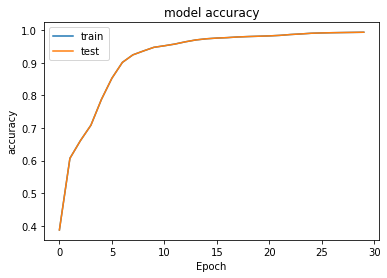

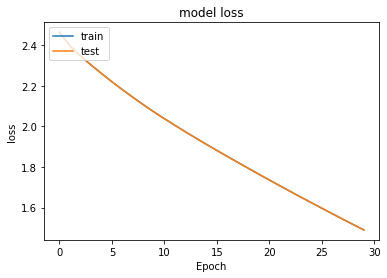

------ Confusion matrix ---------
---------  ---------
[[0.06250108 0.06325305 0.06366076 ... 0.151188   0.06100519 0.08888178]
 [0.07130997 0.07683211 0.06539078 ... 0.0804852  0.07351337 0.1887451 ]
 [0.07822894 0.07072238 0.07030603 ... 0.09061246 0.06639277 0.08269548]
 ...
 [0.07262745 0.07023066 0.07366613 ... 0.18727775 0.0788969  0.08559482]
 [0.07262744 0.07023065 0.07366614 ... 0.1872777  0.0788969  0.08559483]
 [0.07262744 0.07023065 0.07366614 ... 0.1872777  0.0788969  0.08559483]]
---------  ---------


In [24]:
# Experiment 1: train a decision tree model
num_trees = 10
depth = 10
used_features_rate = 1.0
num_classes = len(TARGET_LABELS)


def create_tree_model():
    inputs = create_model_inputs()
    features = encode_inputs(inputs)
    features = layers.BatchNormalization()(features)
    num_features = features.shape[1]

    tree = NeuralDecisionTree(depth, num_features, used_features_rate, num_classes)

    outputs = tree(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


tree_model = create_tree_model()
run_experiment(tree_model, 1)

Start training the model...
Epoch 1/30
4828/4828 [==============================] - 497s 101ms/step - loss: 2.4771 - sparse_categorical_accuracy: 0.2991 - lr: 1.0000e-05
Epoch 2/30
4828/4828 [==============================] - 479s 99ms/step - loss: 2.4421 - sparse_categorical_accuracy: 0.3617 - lr: 1.0000e-05
Epoch 3/30
4828/4828 [==============================] - 481s 100ms/step - loss: 2.4076 - sparse_categorical_accuracy: 0.4932 - lr: 1.0000e-05
Epoch 4/30
4828/4828 [==============================] - 480s 99ms/step - loss: 2.3746 - sparse_categorical_accuracy: 0.5477 - lr: 1.0000e-05
Epoch 5/30
4828/4828 [==============================] - 473s 98ms/step - loss: 2.3426 - sparse_categorical_accuracy: 0.5445 - lr: 1.0000e-05
Epoch 6/30
4828/4828 [==============================] - 477s 99ms/step - loss: 2.3112 - sparse_categorical_accuracy: 0.5588 - lr: 1.0000e-05
Epoch 7/30
4828/4828 [==============================] - 470s 97ms/step - loss: 2.2799 - sparse_categorical_accuracy: 0.6067 

INFO:tensorflow:Assets written to: model_ndf2/assets


INFO:tensorflow:Assets written to: model_ndf2/assets


Evaluating the model on the test data...
1080/1080 [==============================] - 18s 16ms/step - loss: 1.6715 - sparse_categorical_accuracy: 0.8140
------ Accuracy ---------
Test accuracy: 81.4%
------ Graphic ---------
dict_keys(['loss', 'sparse_categorical_accuracy', 'lr'])


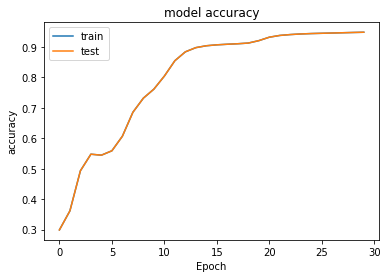

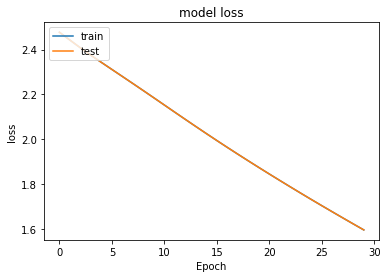

------ Confusion matrix ---------
---------  ---------
[[0.06383611 0.06469453 0.05772295 ... 0.15695438 0.06849709 0.09998203]
 [0.06102009 0.06945354 0.05829241 ... 0.09472796 0.06728701 0.17701234]
 [0.06465246 0.06481962 0.05741186 ... 0.14910085 0.06954792 0.10837723]
 ...
 [0.06420726 0.06670666 0.06009846 ... 0.16696319 0.06808955 0.09732972]
 [0.06420726 0.06670667 0.06009847 ... 0.1669631  0.06808956 0.09732975]
 [0.06420726 0.06670667 0.06009847 ... 0.1669631  0.06808956 0.09732975]]
---------  ---------


In [25]:
# Experiment 2: train a forest model
num_trees = 25
depth = 5
used_features_rate = 0.5
num_classes = len(TARGET_LABELS)


def create_forest_model():
    inputs = create_model_inputs()
    features = encode_inputs(inputs)
    features = layers.BatchNormalization()(features)
    num_features = features.shape[1]

    forest_model = NeuralDecisionForest(
        num_trees, depth, num_features, used_features_rate, num_classes
    )

    outputs = forest_model(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model



forest_model = create_forest_model()

run_experiment(forest_model, 2)

-------------------------------------------------------------------------------

## Teste

In [26]:
learning_rate = 0.00001
batch_size = 265
num_epochs = 30
hidden_units = [64, 64]


def run_experiment(model, model_type):

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )
    
    print("Iniciando teste")
    model_name = "model_ndf" + str(model_type)
    model_name = "best_models/" + model_name
    print("Evaluating the model on the test data...")
    model = keras.models.load_model(model_name)
    test_dataset = get_dataset_from_csv(test_data_file, batch_size=batch_size)

    _, accuracy = model.evaluate(test_dataset)
    print("------ Accuracy ---------")

    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    # print("------ Confusion matrix ---------")
    # y_pred = model.predict(test_dataset)
    # print("---------  ---------")
    # print(y_pred)
    # print("---------  ---------")
    
    # y_teste = model.get_layer(name = 'device_model')
    # confusion_matrix = metrics.confusion_matrix(y_teste, np.rint(y_pred))
    # print(confusion_matrix)
    # https://stackoverflow.com/questions/56458526/get-confusion-matrix-from-a-keras-model


In [27]:
# Experiment 1: train a decision tree model
num_trees = 10
depth = 10
used_features_rate = 1.0
num_classes = len(TARGET_LABELS)


def create_tree_model():
    inputs = create_model_inputs()
    features = encode_inputs(inputs)
    features = layers.BatchNormalization()(features)
    num_features = features.shape[1]

    tree = NeuralDecisionTree(depth, num_features, used_features_rate, num_classes)

    outputs = tree(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


tree_model = create_tree_model()
run_experiment(tree_model, 1)

Iniciando teste
Evaluating the model on the test data...
1080/1080 [==============================] - 11s 10ms/step - loss: 2.2800 - sparse_categorical_accuracy: 0.8061
------ Accuracy ---------
Test accuracy: 80.61%


In [28]:
# Experiment 2: train a forest model
num_trees = 25
depth = 5
used_features_rate = 0.5
num_classes = len(TARGET_LABELS)


def create_forest_model():
    inputs = create_model_inputs()
    features = encode_inputs(inputs)
    features = layers.BatchNormalization()(features)
    num_features = features.shape[1]

    forest_model = NeuralDecisionForest(
        num_trees, depth, num_features, used_features_rate, num_classes
    )

    outputs = forest_model(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model



forest_model = create_forest_model()

run_experiment(forest_model, 2)

Iniciando teste
Evaluating the model on the test data...
1080/1080 [==============================] - 17s 14ms/step - loss: 1.6867 - sparse_categorical_accuracy: 0.8075
------ Accuracy ---------
Test accuracy: 80.75%


In [29]:
# Relatorio de metricas
# print(classification_report(ypred, Y_test))
